In [ ]:
#!pip install -U PyMuPDF pillow langchain-openai
#!pip install -U tabulate
#!pip install -U pytesseract
#!pip install -U langchain_unstructured
#!pip install -U matplotlib

## Initialization

In [ ]:
import os
import re
import json
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain_core.documents.base import Document
from tqdm.auto import tqdm
from collections import defaultdict

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

OPENAI_API_KEY  = os.getenv('OPENAI_API_KEY')
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
UNSTRUCTURED_API_KEY = os.getenv('UNSTRUCTURED_API_KEY')

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)

### Initial PDF Stripping

In [ ]:
import fitz  # PyMuPDF
from langchain_unstructured import UnstructuredLoader

# Define the file path and page range
file_paths = {
    "original": "./data/PHB_2024_O.pdf",
    "short": "./data/PHB_2024_O_Short.pdf",
    "fromMD": "./data/PHB_2024_FromMD.pdf",
}
pages_to_extract = range(5, 346)  # Page numbers to extract

# Check if the original file exists
if os.path.exists(file_paths.original):
    # Check if the output file already exists
    if not os.path.exists(file_paths.short):
        print(f"Creating {file_paths.short}...")
        doc = fitz.open(file_paths.original)
        pdf_writer = fitz.open()  # Create an empty PDF

        for page_num in tqdm(pages_to_extract, desc="Extracting pages"):
            pdf_writer.insert_pdf(doc, from_page=page_num, to_page=page_num)

        pdf_writer.save(file_paths.short)
        pdf_writer.close()
        doc.close()
    else:
        print(f"{file_paths.short} already exists. Skipping creation.")
        final_path = file_paths.short
elif os.path.exists(file_paths.short):
    final_path = file_paths.short
else:
    print(f"{file_paths.original} does not exist. Please check the file path.")

./PHB_2024_O_Short.pdf already exists. Skipping creation.


## Functions

### Helper functions

In [76]:
from IPython.display import HTML, display
from pprint import pprint

# Prints the content of a document. Displaying tables as HTML.
def print_doc_content(doc):
    if doc.metadata['category'] == "Table" and "text_as_html" in doc.metadata:
        display(HTML(doc.metadata["text_as_html"]))
    else:
        pprint(doc.page_content, width=100)

# Prints the content of documents or a specific page if provided.
def check_docs(documents: list, page_num: int = None) -> None:
    """
    Checks and prints the content of documents.


    If a page number is provided, only prints documents with that page number.
    Otherwise, prints all documents.
    """
    for doc in documents:
        if page_num is None:
            print(f"Page: {doc.metadata['page_number']}")
            print_doc_content(doc)
        elif doc.metadata['page_number'] == page_num:
            print_doc_content(doc)

### Define OCR Configurations

In [ ]:
import pytesseract

# Set the path for Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

"""OCR Configuration Parameters
--oem: Specifies the OCR Engine Mode. 1 uses the LSTM-based OCR engine for higher accuracy.
--psm: Page segmentation mode, which determines how Tesseract splits the text (e.g., 3 for blocks of text, 6 for uniform text blocks).
tessedit_char_whitelist: Restricts recognized characters to uppercase letters and digits for titles.
preserve_interword_spaces: Keeps spaces between words intact, important for structured text.
textord_space_size_is_variable: Allows variable spacing, helpful for irregular text spacing in titles or tables.
textord_min_space: Sets minimum distance between characters to interpret as space, preventing word merging.
textord_max_noise_size: Sets maximum size of noise that Tesseract should ignore, reducing interference from artifacts."""
ocr_configs = {
    "Title": (
        r'--oem 1 --psm 6'                           # Treat as a single uniform block of text (good for titles)
        r'-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ' # Prioritize uppercase letters and numbers
        r'-c preserve_interword_spaces=1'            # Ensure spaces between words are preserved
        r'-c textord_space_size_is_variable=1'       # Allow variable-sized spacing between words
        r'-c textord_min_space=3.0'                  # Increase minimum space between characters to avoid merging
        r'-c textord_max_noise_size=8'               # Filter out small noise, focusing on readable characters
    ),
    "Text": (
        r'--oem 1 --psm 3 '                          # Treat as standard text block (paragraphs)
        #r'-c textord_space_size_is_variable=1 '     # Allow variable-sized spacing between words
        #r'-c textord_min_space=2.5 '                # Tighter spacing suitable for standard text paragraphs
        #r'-c textord_max_noise_size=10'             # Higher noise tolerance to filter out small artifacts
    ),
    "Table": (
        r'--oem 1 --psm 6 '                          # Treat as a uniform block, ideal for tables
        r'-c preserve_interword_spaces=1 '           # Preserve interword spaces for structured cell separation
        #r'-c textord_space_size_is_variable=1 '     # Allow variable-sized spacing for cell separation
        #r'-c textord_min_space=5.0 '                # Higher minimum space to avoid merging within table cells
        #r'-c textord_max_noise_size=8'              # Filter out small noise in table text
    ),
    "NarrativeText": (
        r'--oem 1 --psm 4 '                          # Multiple columns mode, suited for narrative sections
        #r'-c textord_space_size_is_variable=1 '     # Allow variable-sized spacing
        #r'-c textord_min_space=2.5 '                # Moderate spacing, suitable for paragraph text
        #r'-c textord_max_noise_size=10'             # Higher tolerance to ignore minor noise artifacts
    )
}

valid_categories = ["Title", "Text", "Table", "NarrativeText"]

### Processing Functions

In [ ]:
# Convert page segment to image based on coordinates
def render_segment_to_image(pdf_page, metadata, dpi=600):
    # Extract coordinates and scale to page dimensions
    points = metadata["coordinates"]["points"]
    layout_width = metadata["coordinates"]["layout_width"]
    layout_height = metadata["coordinates"]["layout_height"]
    
    scaled_points = [
        (int(x * pdf_page.rect.width / layout_width), int(y * pdf_page.rect.height / layout_height))
        for x, y in points
    ]
    
    x_min, y_min = min(p[0] for p in scaled_points), min(p[1] for p in scaled_points)
    x_max, y_max = max(p[0] for p in scaled_points), max(p[1] for p in scaled_points)
    rect = fitz.Rect(x_min, y_min, x_max, y_max)
    
    # Render the defined region as an image
    pix = pdf_page.get_pixmap(clip=rect, dpi=dpi)
    return Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

# Check if title is valid
def is_valid_title(text):
    # Titles should be reasonably long and contain words
    if len(text) < 3 or not re.search(r'[A-Z]', text):  # Ensure text has at least one uppercase letter
        return False
    # Remove non-alphanumeric and check if it's still a readable phrase
    cleaned_text = re.sub(r'[^A-Z0-9 ]+', '', text).strip()
    if not cleaned_text.strip():
        return False
    return True

# Apply OCR with error-checking for valid titles
def apply_ocr(image, config):
    raw_text = pytesseract.image_to_string(image, config=config).strip()
    if config == ocr_configs["Title"]:
        # Filter out potential garbage or misread titles
        if is_valid_title(raw_text):
            return raw_text
        else:
            return ""  # Return empty if the title seems invalid
    return raw_text

# Process documents based on category
def process_docs(docs, file_path, categories=["Title"]):
    reprocessed_docs = []
    pdf_document = fitz.open(file_path)
    
    for doc in tqdm(docs, desc="Processing document segments"):
        category = doc.metadata.get("category")
        page_number = doc.metadata.get("page_number", 0) - 1  # Zero-based page index
        config = ocr_configs.get(category)
        
        # Only process if the document's category is in the specified categories list
        if category in categories and config:
            pdf_page = pdf_document.load_page(page_number)
            img = render_segment_to_image(pdf_page, doc.metadata)
            corrected_text = apply_ocr(img, config)
            doc.page_content = corrected_text  # Update content with corrected OCR text
            
        # Append processed or unmodified document to reprocessed_docs
        reprocessed_docs.append(doc)
    
    pdf_document.close()
    return reprocessed_docs

# Filter relevant document segments
def filter_docs(docs, valid_categories):
    return [
        doc for doc in docs
        if doc.metadata.get('category') in valid_categories and len(doc.page_content.strip()) > 2 and doc.page_content != ""
    ]

# Remove empty documents
def remove_empty_docs(docs):
    return [doc for doc in docs if doc.page_content.strip()]

In [ ]:
# Combine Text documents between Titles
def combine_text_documents(documents):
    combined_docs = []
    buffer_content = []
    buffer_metadata = None

    for doc in documents:
        category = doc.metadata['category']

        if category == 'Title':
            # If there's content in the buffer, create a combined document
            if buffer_content:
                combined_docs.append(Document(
                    page_content=' '.join(buffer_content),
                    metadata=buffer_metadata
                ))
                buffer_content = []

            # Add the Title document to the combined_docs list
            combined_docs.append(doc)

        elif category in {'Text', 'NarrativeText'}:
            # If the buffer is empty, set the metadata for the combined document
            if not buffer_content:
                buffer_metadata = {**doc.metadata, 'category': 'Text'}

            # Add the current document's content to the buffer
            buffer_content.append(doc.page_content)

        else:
            # If there's content in the buffer, create a combined document
            if buffer_content:
                combined_docs.append(Document(
                    page_content=' '.join(buffer_content),
                    metadata=buffer_metadata
                ))
                buffer_content = []

            # Add the current document to the combined_docs list
            combined_docs.append(doc)

    # After the loop, check if there's remaining content in the buffer
    if buffer_content:
        combined_docs.append(Document(
            page_content=' '.join(buffer_content),
            metadata=buffer_metadata
        ))

    return combined_docs

### Convert to DataFrame and further processing

In [ ]:
# Convert Langchain documents to a pandas DataFrame
def documents_to_dataframe(doc_list: list) -> pd.DataFrame:
    # Initialize lists to hold page content and metadata
    page_contents = []
    metadata_list = []

    for doc in doc_list:
        page_contents.append(doc.page_content)
        metadata_list.append(doc.metadata)

    # Create individual DataFrames for page content and metadata
    content_df = pd.DataFrame({'page_content': page_contents})
    metadata_df = pd.json_normalize(metadata_list)

    df = pd.concat([content_df, metadata_df], axis=1)

    return df

In [ ]:
# Define known chapters
known_chapters = {
    "1": "CHAPTER 1 | PLAYING THE GAME",
    "2": "CHAPTER 2 | CREATING A CHARACTER",
    "3": "CHAPTER 3 | CHARACTER CLASSES",
    "4": "CHAPTER 4 | CHARACTER ORIGINS",
    "5": "CHAPTER 5 | FEATS",
    "6": "CHAPTER 6 | EQUIPMENT",
    "7": "CHAPTER 7 | SPELLS"
}

# Assign chapters column based on known chapters
def assign_chapters(df):
    # Initialize the 'chapter' column
    df['chapter'] = None
    current_chapter = None

    # Group by page number to process each page separately
    for page, group in df.groupby('page_number'):
        # Get the last row in this page group
        last_row = group.iloc[-1]
        
        # Check if the last row's category is "Title" and contains "CHAPTER"
        if last_row['category'] == "Title" and "CHAPTER" in last_row['page_content'].upper():
            # Extract the chapter number
            match = re.search(r'\bCHAPTER\s+(\d+)\b', last_row['page_content'], re.IGNORECASE)
            if match:
                chapter_number = match.group(1).strip()
                # Get the corresponding chapter title from known chapters
                current_chapter = known_chapters.get(chapter_number, current_chapter)
        
        # Assign the current chapter to all rows on this page
        df.loc[df['page_number'] == page, 'chapter'] = current_chapter

    return df

In [ ]:
# Exclude rows that are chapter footers based on the pattern 'CHAPTER X | TITLE'
def exclude_chapter_footers(group):
    # Exclude rows where 'category' is 'Title' and 'page_content' matches the chapter footer pattern
    return group[~((group['category'] == "Title") & group['page_content'].str.contains(r'CHAPTER\s+\d+\s+\|', case=False, na=False))]

# Organize content into sections based on titles within each page group
def organize_content_into_sections(group):
    sections = []
    current_section = []
    last_title = None

    for _, row in group.iterrows():
        if row['category'] == "Title":
            if last_title:
                sections.append((last_title, current_section))
            last_title = row['page_content']
            current_section = []
        else:
            current_section.append(row)

    if last_title:
        sections.append((last_title, current_section))

    return sections

# Summarize text and table content within each section, pairing tables with their HTML
def add_text_and_table_summaries(sections):
    summarized_sections = []

    for title, content in sections:
        summarized_content = []
        tables_html = {}

        for item in content:
            if item['category'] == "Text":
                summarized_content.append(item['page_content'])
            elif item['category'] == "Table":
                table_summary_key = f"Table: {title}" if title else f"Table: {item['page_number']}_{item.name}"
                summarized_content.append(f"{table_summary_key}: {item['page_content']}")
                tables_html[table_summary_key] = item['text_as_html']

        summarized_sections.append((title, summarized_content, tables_html))

    return summarized_sections

# Combine all sections' content into a single string for the page
def combine_page_content(summarized_sections):
    page_content = []

    for title, content, _ in summarized_sections:
        page_content.append(f"\n{title}:\n" + " ".join(content) + "\n")

    return " ".join(page_content).strip()

# Main function to process the DataFrame and structure the content by page
def process_page_content(df):
    processed_pages = []

    for page_number, group in df.groupby('page_number'):
        group = exclude_chapter_footers(group)
        sections = organize_content_into_sections(group)
        summarized_sections = add_text_and_table_summaries(sections)
        combined_text = combine_page_content(summarized_sections)

        # Combine all tables_html dictionaries
        combined_tables_html = {}
        for _, _, tables_html in summarized_sections:
            for key, value in tables_html.items():
                if key in combined_tables_html:
                    # Handle duplicate keys if necessary
                    combined_tables_html[key + "_duplicate"] = value
                else:
                    combined_tables_html[key] = value

        processed_pages.append({
            "page_number": page_number,
            "chapter": group['chapter'].iloc[0] if not group['chapter'].isna().all() else None,
            "page_content": combined_text,
            "tables_html": combined_tables_html
        })

    return pd.DataFrame(processed_pages)

### Save and Load JSON

In [ ]:
# Save a list of Document objects to JSON
def save_to_json(docs, output_json_path):
    json_data = [{
        "metadata": doc.metadata,
        "page_content": doc.page_content
        }
        for doc in docs
    ]

    with open(output_json_path, "w", encoding="utf-8") as json_file:
        json.dump(json_data, json_file, ensure_ascii=False, indent=4)
        
# Load JSON data back into Document objects
def load_documents_from_json(json_path):
    with open(json_path, "r", encoding="utf-8") as json_file:
        json_data = json.load(json_file)

    loaded_docs = [
        Document(metadata=doc["metadata"], page_content=doc["page_content"])
        for doc in json_data
    ]

    return loaded_docs

## PDF Processing

### Unstructured Loader initialization

In [ ]:
# Initialize UnstructuredLoader for initial processing
loader = UnstructuredLoader(
    file_path=[final_path],
    strategy="hi_res",
    languages=["eng"],
    partition_via_api=True, # Flase to use local processing
    coordinates=True,
)

### Initial processing with UnstructuredLoader

In [ ]:
# Perform initial loading with UnstructuredLoader to extract elements and metadata
docs = []
for doc in tqdm(loader.lazy_load(), desc="Processing pages"):
    docs.append(doc)

Processing pages: 0it [00:00, ?it/s]

INFO: Preparing to split document for partition.
INFO: Starting page number set to 1
INFO: Allow failed set to 0
INFO: Concurrency level set to 5
INFO: Splitting pages 1 to 341 (341 total)
INFO: Determined optimal split size of 20 pages.
INFO: Partitioning 17 files with 20 page(s) each.
INFO: Partitioning 1 file with 1 page(s).
INFO: Partitioning set #1 (pages 1-20).
INFO: Partitioning set #2 (pages 21-40).
INFO: Partitioning set #3 (pages 41-60).
INFO: Partitioning set #4 (pages 61-80).
INFO: Partitioning set #5 (pages 81-100).
INFO: Partitioning set #6 (pages 101-120).
INFO: Partitioning set #7 (pages 121-140).
INFO: Partitioning set #8 (pages 141-160).
INFO: Partitioning set #9 (pages 161-180).
INFO: Partitioning set #10 (pages 181-200).
INFO: Partitioning set #11 (pages 201-220).
INFO: Partitioning set #12 (pages 221-240).
INFO: Partitioning set #13 (pages 241-260).
INFO: Partitioning set #14 (pages 261-280).
INFO: Partitioning set #15 (pages 281-300).
INFO: Partitioning set #16 (p

In [64]:
check_docs(docs, 8)

'Yt'
'T#;Y."H'
'E'
'/'
'o'
'S,'
'I'
'ß'
'o'
'Mame”,'
'7'
'P'
'I'
'3'
'L 8 %'
'/!'
'II'
'I'
'\\'
'li'
"[  \nA D20 Test can Regularly result in a character's success,"
'A SIMPLE ACCOMPLISHMENT, OR A CATASTROPHE'
'./_'
'ü -;,'
'A'
'y'
''
'I'
'o)'
',('
'o a ¥ .'
'I'
't <1'
''
'.l1'
'n'
'O'
'¥'
'\\‘d-*\\ ” X 4 "l 4 \' \\ I 4'
'/|'
'Z'
't'
'Ii'
')'
't'
't\\'
'\\'
'\\'
'\\'
"l'-1 §"
'»'
'o'
'<~ X'
''
'I'
'"'
', ,i,'
'»'
'I'
'i'
'7'
"I'"
'ABILITY CHECK EXAMPLES'


Ability,Make a Check To ...
Strength,"Lift, push, pull, or break something"
Dexterity,"Move nimbly, quickly, or quietly"
Constitution,Push your body beyond normal limits
Intelligence,Reason or remember
Wisdom,Notice things in the environment or in creatures’ behavior
Charisma,"Influence, entertain, or deceive"


'PROFICIENCY BONUS'
('Add your Proficiency Bonus to an ability check when the DM determines that a skill or tool '
 'proficiency is relevant to the check and you have that proficiency. For example, if a rule '
 'refers to a Strength (Acrobatics or Athletics) check, you can add your Proficiency Bonus to the '
 'check if you have proficiency in the Acrobatics or Athletics skill. See "Proficiency" later in '
 'this chapter for more information about skill and tool proficiencies.')
'DIFFICULTY CLASS'
("The Difficulty Class of an ability check represents the task's difficulty. The more difficult "
 'the task, the higher its DC. The rules provide DCs for certain checks, but the DM ultimately '
 'sets them. The typical Difficulty Classes table presents a range of possible DCs for ability '
 'checks.')
'Typical Difficulty Classes'
('[Table]  \n'
 'Task Difficulty DC  \n'
 'Very easy 5  \n'
 'Easy 10  \n'
 'Medium 15  \n'
 'Hard 20  \n'
 'Very hard 25  \n'
 'Nearly impossible 30')


Task Difficulty,DC,Task Difficulty,DC
Very easy,5,Hard,20
Easy,10,Very hard,25
Medium,15,Nearly impossible,30


('[NarrativeText]  \n'
 'A saving throw—also called a save—represents an attempt to evade or resist a threat, such as a '
 "fiery explosion, a blast of poisonous gas, or a spell trying to invade your mind. You don't "
 "normally choose to make a save; you must make one because your character or a monster (if you're "
 "the DM) is at risk. A save's result is detailed in the effect that caused it.")
"If you don't want to resist the effect, you can choose to fail the save without rolling."
'[Title]  \nABILITY MODIFIER'
('[NarrativeText]  \n'
 'Saving throws are named for the ability modifiers they use: a Constitution saving throw, a '
 'Wisdom saving throw, and so on. Different saving throws are used to resist different kinds of '
 'effects, as shown on the Saving Throw Examples table.')
'[Title]  \nCHAPTER 1 | PLAYING THE GAME'
'CHAPTER 1 | PLAYING THE GAME'
'IT'


### Advanced OCR Processing

In [ ]:
stripped_docs = remove_empty_docs(filter_docs(docs, valid_categories))
reprocessed_docs = process_docs(stripped_docs, final_path)
#save_to_json(reprocessed_docs, "./data/reprocessed_docs.json")
combined_docs = combine_text_documents(reprocessed_docs)

Processing document segments:   0%|          | 0/19812 [00:00<?, ?it/s]

In [65]:
check_docs(reprocessed_docs, 7)

'[  \nTHE SIX ABILITIES'
('All creatures—characters and monsters—have six abilities that measure physical and mental '
 'characteristics, as shown on the Ability Descriptions table.')
'ABILITY DESCRIPTIONS'


Ability
Strength
Dexterity
Constitution
Intelligence
Wisdom
Charisma


'ABILITY SCORES'
('Each ability has a score from 1 to 20, although some monsters have a score as high as 30. The '
 'score represents the magnitude of an ability. The Ability Scores table summarizes what the '
 'scores mean.')
'ABILITY SCORES'


Score,Meaning
1,"This is the lowest a score can normally go. If an effect reduces a score to 0, that effect explains what happens."
2-9,This represents a weak capability.
10-1,This represents the human average.
12-19,This represents a strong capability.
20,This is the highest an adventurer’s score can go unless a feature says otherwise.
21-29,This represents an extraordinary capability.
30,This is the highest a score can go.


'ABILITY MODIFIERS'
('Each ability has a modifier that you apply whenever you make a d20 Test with that ability '
 '(explained in "D20 Tests"). An ability modifier is derived from its score, as shown in the '
 'Ability Modifiers table.')
'ABILITY MODIFIERS'


Score,Modifier,Score,Modifier
1,-5,16-17,+3
2-3,-4,18-19,+4
4-5,-3,20-21,+5
6-7,-2,22-23,+6
8-9,-1,24-25,+7
10-1,+0,26-27,+8
12-13,+1,28-29,+9
14-15,+2,30,+.l0


'D20 TESTS'
('When the outcome of an action is uncertain, the game uses a d20 roll to determine success or '
 'failure. These rolls are called D20 Tests, and they come in three kinds: ability checks, saving '
 'throws, and attack rolls. They follow these steps:')
('1: Roll 1d20. You always want to roll high. If the roll has Advantage or Disadvantage (described '
 'later in this chapter), you roll two d20s, but you use the number from only one of them—the '
 'higher one if you have Advantage or the lower one if you have Disadvantage.')
'2: Add Modifiers. Add these modifiers to the number rolled on the d20:'
'The rules glossary explains which ability modifiers to use for various D20 Tests.'
('A creature has a Proficiency Bonus, a number added when making a d20 Test that uses something, '
 'such as a skill, in which the creature has proficiency. See "Proficiency" later in this chapter.')
'A feature, a spell, or another rule might give a bonus or penalty to the die roll.'
('3: Compare the 

### Dataframe Processing

In [ ]:
df = documents_to_dataframe(combined_docs)
df = df[['category', 'page_content', 'page_number', 'text_as_html']]
df = assign_chapters(df)
df = df.replace({'page_content': ''}, pd.NA)
df = df.dropna(subset=['page_content'])
processed_df = process_page_content(df)

# Save df to a csv file
df.to_csv('./data/combined_docs.csv', index=False)
processed_df.to_csv('./data/combined_dataframes.csv', index=False)

## LLM Corrector (WIP)

### Prompt

In [38]:
from langchain.prompts import PromptTemplate

# Define prompt template with improved context instructions
prompt_template = PromptTemplate(
    input_variables=["page_text", "page_number", "image"],
    template=(
        "This is the OCR-extracted text from page {page_number} of the Dungeons & Dragons Player Handbook. "
        "Please refer to the attached image of the page (provided as 'image') to review and correct any OCR errors, "
        "especially issues with spacing, uppercase recognition, and unusual characters. "
        "Here's the OCR text:\n\n{page_text}\n\n"
        "Using the image as a reference, provide the corrected text as accurately as possible, "
        "maintaining any separation between sections."
        "Don't add any additional notes or explanations."
    )
)
llm_chain = prompt_template | llm

### Define Functions

In [ ]:
import fitz
from PIL import Image

# Cache to store images and corrected text by page number
page_image_cache = {}
page_text_cache = {}

# Group docs by page number
docs_by_page = defaultdict(list)
for doc in reprocessed_docs:
    page_number = doc.metadata.get("page_number")
    docs_by_page[page_number].append(doc)

# Function to convert a PDF page to an image if not already cached
def get_page_image(file_path, page_number, dpi=300):
    if page_number in page_image_cache:
        return page_image_cache[page_number]
    
    pdf_document = fitz.open(file_path)
    try:
        page = pdf_document.load_page(page_number - 1)
        pix = page.get_pixmap(dpi=dpi)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        page_image_cache[page_number] = img
    finally:
        pdf_document.close()
    
    return img

# Function to filter out irrelevant segments
def filter_irrelevant_segments(page_docs):
    filtered_text = ""
    for doc in page_docs:
        content = doc.page_content.strip()
        category = doc.metadata.get("category")
        
        # Filter criteria: relevant categories, non-empty, and reasonably informative content
        if category in ["Title", "Text", "Table", "NarrativeText"] and len(content) > 2:
            filtered_text += f"\n[{category}]\n{content}\n"
    return filtered_text.strip()

### Correct docs

In [ ]:
### Single page test
from pprint import pprint

p_text = ""
for doc in reprocessed_docs:
    if doc.metadata['page_number'] == 7:
        if doc.metadata['category'] != "Table":
            p_text += f"\n{doc.page_content}"
            
        prompt_input = {
            "page_text": p_text,
            "page_number": doc.metadata['page_number'],
            "image": get_page_image(final_path, doc.metadata['page_number'])
            }

response = llm_chain.invoke(prompt_input)
corrected_page_text = response.content.strip()

In [ ]:
### Full document
# Process each page group to minimize API calls
corrected_docs = []
for page_number, page_docs in tqdm(docs_by_page.items(), desc="Correcting OCR errors by page"):
    # Filter and concatenate relevant text for this page
    filtered_page_text = filter_irrelevant_segments(page_docs)
    
    # Skip LLM correction if there's no relevant content on this page
    if not filtered_page_text:
        corrected_docs.extend(page_docs)
        continue

    # Use cached corrected text if available
    if page_number not in page_text_cache:
        # Get the page image to pass along with text to the LLM
        page_image = get_page_image(final_path, page_number)
        
        # Set up the prompt input with both text and image
        prompt_input = {
            "page_text": filtered_page_text,
            "page_number": page_number,
            "image": page_image
        }
        
        # Run the LLM to get corrected text
        response = llm_chain.invoke(prompt_input)
        corrected_page_text = response.content.strip()
        
        # Cache the corrected text for this page
        page_text_cache[page_number] = corrected_page_text
    else:
        corrected_page_text = page_text_cache[page_number]
    
    # Split corrected text back into segments by category
    corrected_segments = corrected_page_text.split("\n[")
    corrected_segments = ["[" + seg for seg in corrected_segments if seg.strip()]

    # Map corrected segments back to their original docs, with fallback if mismatch occurs
    segment_index = 0
    for doc in page_docs:
        if doc.metadata.get("category") in ["Title", "Text", "Table", "NarrativeText"]:
            # Ensure segment_index is within bounds of corrected_segments
            if segment_index < len(corrected_segments):
                corrected_text = corrected_segments[segment_index].replace(f"[{doc.metadata['category']}]", "").strip()
                doc.page_content = corrected_text
                segment_index += 1
            else:
                # Log warning and retain original text in case of mismatch
                print(f"Warning: Segment mismatch on page {page_number}. Retaining original content for doc ID {doc.metadata['element_id']}")
                doc.page_content = doc.page_content  # Keep original if mismatch occurs
        
        # Append the document to corrected_docs
        corrected_docs.append(doc)

# `corrected_docs` now contains all text elements with improved OCR for relevant segments.

Correcting OCR errors by page:   0%|          | 0/12 [00:00<?, ?it/s]

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


## Rendering PDFs

In [ ]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(final_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            pprint(f"{doc.page_content}\n")

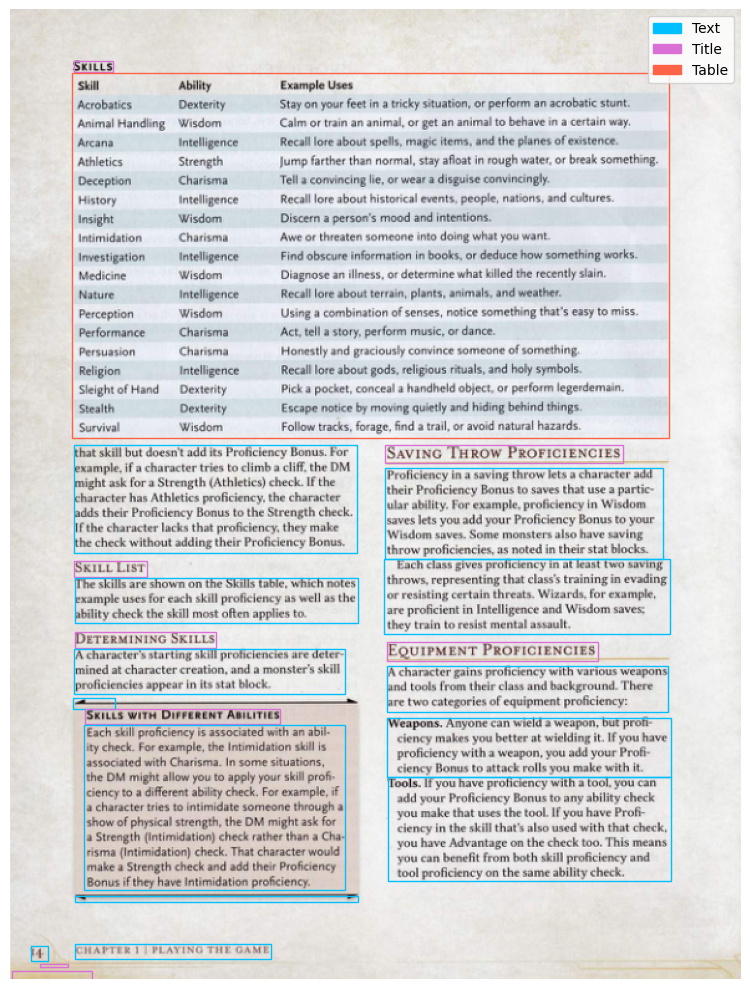

'SKILLS\n'
('Ability skill Example Uses Stay on your feet in a tricky situation, or '
 'perform an acrobatic stunt. Dexterity Acrobatics Calm or train an animal, or '
 'get an animal to behave in a certain way. Wisdom Animal Handling Recall lore '
 'about spells, magic items, and the planes of existence. lntelligence Arcana '
 'Jump farther than normal, stay afloat in rough water, or break something '
 'Athletics Strength Tell a convincing lie, or wear a disguise convincingly. '
 'Charisma Deception Recall lore about historical events, people, nations, and '
 "cultures. lntelligence History Discern a person's mood and intentions. "
 'lnsight Wisdom Awe or threaten someone into doing what you want. '
 'lntimidation Charisma Find obscure information in books, or deduce how '
 'something works. lnvestigation lntellige nce Diagnose an illness, or '
 'determine what killed the recently slain. Wisdom Medicine Recall lore about '
 "terrain, plants, animals, and weather' lntelligence N atu re 

In [76]:
render_page(docs, 16)